# BO RDB v

* 모델 생성
* 목적함수 생성

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

## Model 생성

### knobs 종류, 바운드 입력

In [16]:
knobs_rdb = {
#     "save0_0": (700,1100),
#     "save0_1": (1,9),
#     "save1_0": (100,500),
#     "save1_1": (10,100),
#     "save2_0": (30,90),
#     "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'),
    "rdbchecksum": ('yes', 'no'),
    "rdb-save-incremental-fsync": ('yes', 'no'),

    "activedefrag": ('yes', 'no'),
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    # "maxmemory": None,
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no'),

    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

In [17]:
# 확인
print(knobs_bound)

[('yes', 'no'), ('yes', 'no'), ('yes', 'no'), ('yes', 'no'), (1, 31), (70, 101), (1, 31), (70, 91), ('volatile-lru', 'allkeys-lru', 'volatile-lfu', 'allkeys-lfu', 'volatile-random', 'allkeys-random', 'volatile-ttl', 'noeviction'), (3, 7), ('yes', 'no'), ('yes', 'no'), ('yes', 'no'), (256, 751), (16, 257), ('yes', 'no'), (1, 41), ('yes', 'no')]


# 0. config data의 csv 파일 처리
csv 파일은 confile.conf 파일에서 선별한 knob 값들을 파싱하여 저장된 상태이다. 
* config_df 는 랜덤하게 값을 할당한 모든 변수 존재한다. 
* 부분적으로 knob 선별 작업 필요!

### csv 파일 가져오기

In [18]:
# config data(.csv) -> DataFrame
config_df = pd.read_csv("./result_config10001_11000.csv", sep=',')

In [19]:
# 확인
config_df

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,rdbcompression,rdbchecksum,rdb-save-incremental-fsync,...,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,no,...,volatile-lfu,7,no,yes,no,636,235,yes,7,no
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,no,...,volatile-random,3,no,yes,yes,392,67,yes,21,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,yes,...,volatile-lfu,7,yes,yes,yes,699,94,yes,37,yes
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,yes,no,...,volatile-lfu,7,yes,no,yes,400,136,no,9,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,no,...,volatile-lru,7,yes,no,no,663,218,no,12,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,yes,...,allkeys-lfu,3,yes,yes,no,626,149,yes,13,no
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,no,...,volatile-random,6,yes,yes,yes,745,129,yes,31,yes
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,no,no,...,volatile-lfu,6,yes,yes,yes,302,101,no,12,yes
998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,yes,...,volatile-lfu,4,no,yes,yes,291,67,yes,19,yes


### null 값 처리

In [20]:
# fillna(value = 0) 0 값으로 채워 넣기
config_df = config_df.fillna(value = 0)

In [21]:
# 확인
## 확인 결과 모두 값이 0이면 제거하는 것이 좋다. !! 자동화 코드 만들 필요!
config_df.head()

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,rdbcompression,rdbchecksum,rdb-save-incremental-fsync,...,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,no,...,volatile-lfu,7,no,yes,no,636,235,yes,7,no
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,no,...,volatile-random,3,no,yes,yes,392,67,yes,21,yes
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,no,yes,...,volatile-lfu,7,yes,yes,yes,699,94,yes,37,yes
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no,yes,no,...,volatile-lfu,7,yes,no,yes,400,136,no,9,no
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,yes,yes,no,...,volatile-lru,7,yes,no,no,663,218,no,12,no


### 카테고리 형 처리
* numeric
* category

애초에 위 두가지 형태 밖에 존재하지 않는다. numeric의 경우 모두 numeric으로 처리가 된 상태이며, category의 경우 object로 처리가 될것이다. 따라서 Object인 경우에만 category형태로 타입을 변경해준다.

In [22]:
category_knob = []

for knob in config_df:
    if config_df[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        config_df[knob] = config_df[knob].astype('category')
        category_knob.append(knob)

In [23]:
# 확인
category_knob

['rdbcompression',
 'rdbchecksum',
 'rdb-save-incremental-fsync',
 'activedefrag',
 'maxmemory-policy',
 'lazyfree-lazy-eviction',
 'lazyfree-lazy-expire',
 'lazyfree-lazy-server-del',
 'activerehashing',
 'dynamic-hz']

### knob 추출

In [24]:
# knob 들만 추출
config_df_knob = config_df.loc[:,knobs_list]

In [25]:
# 확인
config_df_knob.head()

,rdbcompression,rdbchecksum,rdb-save-incremental-fsync,activedefrag,active-defrag-threshold-lower,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
0,no,no,no,yes,7.0,83.0,12.0,83.0,volatile-lfu,7,no,yes,no,636,235,yes,7,no
1,no,no,no,0,0.0,0.0,0.0,0.0,volatile-random,3,no,yes,yes,392,67,yes,21,yes
2,no,no,yes,yes,28.0,93.0,28.0,86.0,volatile-lfu,7,yes,yes,yes,699,94,yes,37,yes
3,no,yes,no,0,0.0,0.0,0.0,0.0,volatile-lfu,7,yes,no,yes,400,136,no,9,no
4,yes,yes,no,0,0.0,0.0,0.0,0.0,volatile-lru,7,yes,no,no,663,218,no,12,no


### 모두 값이 0일 경우 제거

### result.csv 파일 가져오기

In [26]:
# external data(.csv) -> DataFrame
external_df = pd.read_csv("./result_rdb_external_4.csv", sep=',')
throughput_data = external_df['Gets_KB/sec']

In [27]:
# throuput 값으로 예상 확인
external_df['Gets_KB/sec']

0      68121.32
1      67585.45
2      67425.93
3      67046.94
4      66755.71
         ...   
995    67567.17
996    68655.48
997    67605.50
998    67812.35
999    66795.58
Name: Gets_KB/sec, Length: 1000, dtype: float64

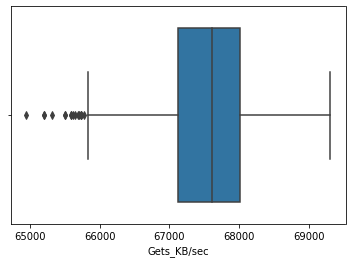

In [28]:
import seaborn as sns
sns.boxplot(x = "Gets_KB/sec",data = external_df )
plt.show()

### train, test 데이터 분리

In [23]:
# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(config_df_knob, throughput_data ,test_size=0.2)


In [24]:
#lightGBM 파라미터 설정
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

In [25]:
lgbr = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)


In [26]:
lgbr.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid's auc: 1


/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


LGBMRegressor(colsample_bytree=0.9, metric='None', n_estimators=1000, n_jobs=4,
              num_leaves=15, random_state=314, subsample=0.9)

In [27]:
# 확인
y_predict = lgbr.predict(X_test)

---

# Bayeian Optimization 진행

### Objective Function 생성

In [77]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):
    knob_dict = {}

    for i, knob in enumerate(knobs_list): # 딕셔너리로 이동
        knob_dict[knob] = knob_value[i]
    
    if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
        activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
        for activ_knob in activ_var:
            knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category')        

    return -lgbr.predict(knob_df)[0]


#     change_numeric = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']


In [78]:
# 테스트 확인
knob_value = ['no',
 'yes',
 'yes',
 'no',
 4.0,
 80.0,
 19.0,
 89.0,
 'volatile-lru',
 5,
 'no',
 'yes',
 'no',
 526,
 32,
 'yes',
 4,
 'yes']

In [79]:
objective_func(knob_value, noise_level)

-67480.14907431688

## gp_minimize 호출

In [30]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [76]:
res = gp_minimize(objective_func,                  # the function to minimize
                  knobs_bound,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [80]:
res.x

['no',
 'yes',
 'yes',
 'no',
 31,
 70,
 1,
 91,
 'volatile-ttl',
 3,
 'no',
 'yes',
 'yes',
 256,
 16,
 'yes',
 41,
 'no']

In [81]:
res.fun # 65000

-67575.17067666372